## **Johannes Scheider, David Karres, Malte Holczinger**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

/home/Johannes/.conda/envs/uni/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/Johannes/.conda/envs/uni/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


### **1 Introduction**

In [2]:
# code as proposed in the exercise
plt.rc("figure", dpi=100)

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# load data:
train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)


test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

# This part is only activated when testing the written code:
# only use a small part of training set:
#train_dataset = torch.utils.data.Subset(train_dataset, range(0, 100))
#test_dataset = torch.utils.data.Subset(test_dataset, range(0, 100))

# Setup dataloader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

# How to initialize the weights of the neural network:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w

# ReLU:
def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)

# The used optimizer class:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])



In [3]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax


# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

In [4]:
# train network
optimizer = RMSprop(params=[w_h, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 3.98e-01
Mean Test Loss:  2.09e-01
Epoch: 10
Mean Train Loss: 1.44e-01
Mean Test Loss:  3.23e-01
Epoch: 20
Mean Train Loss: 1.05e-01
Mean Test Loss:  3.96e-01
Epoch: 30
Mean Train Loss: 7.32e-02
Mean Test Loss:  5.41e-01
Epoch: 40
Mean Train Loss: 4.82e-02
Mean Test Loss:  6.74e-01
Epoch: 50
Mean Train Loss: 3.19e-02
Mean Test Loss:  6.50e-01
Epoch: 60
Mean Train Loss: 3.06e-02
Mean Test Loss:  8.74e-01
Epoch: 70
Mean Train Loss: 2.18e-02
Mean Test Loss:  6.80e-01
Epoch: 80
Mean Train Loss: 1.71e-02
Mean Test Loss:  8.77e-01
Epoch: 90
Mean Train Loss: 1.75e-02
Mean Test Loss:  8.69e-01
Epoch: 100
Mean Train Loss: 1.51e-02
Mean Test Loss:  9.37e-01


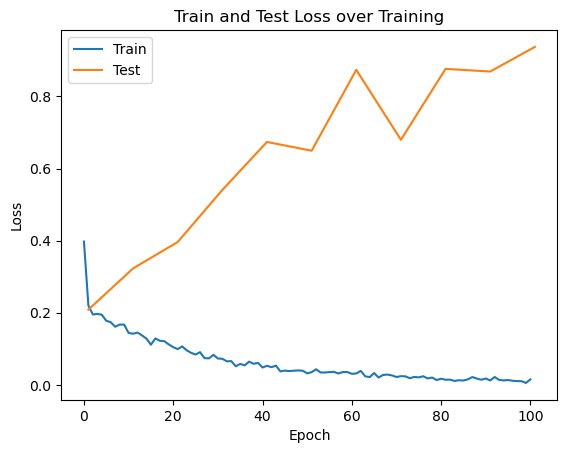

In [5]:
# plot training + test loss
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### **Dropout**

In [6]:
# define dropout layer
def dropout(X, p_drop=0.5):
    if p_drop < 1 and p_drop > 0:
        mask = torch.bernoulli(torch.ones_like(X) * (1 - p_drop))
        X = torch.where(mask==1,0,X/(1-p_drop))
    return X

In [7]:
# setup NN, figure and weights
plt.rc("figure", dpi=100)

batch_size = 100

# define the neural network
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    x = dropout(X,p_drop_input)
    h = rectify(x @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

In [8]:
# train network
optimizer = RMSprop(params=[w_h, w_h2, w_o])

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o,0.5,0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o,0.5,0.5)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 1.02e+00
Mean Test Loss:  6.89e-01
Epoch: 10
Mean Train Loss: 1.05e+00
Mean Test Loss:  1.04e+00
Epoch: 20
Mean Train Loss: 1.27e+00
Mean Test Loss:  1.28e+00
Epoch: 30
Mean Train Loss: 1.58e+00
Mean Test Loss:  1.67e+00
Epoch: 40
Mean Train Loss: 1.68e+00
Mean Test Loss:  1.75e+00
Epoch: 50
Mean Train Loss: 1.92e+00
Mean Test Loss:  1.73e+00
Epoch: 60
Mean Train Loss: 1.97e+00
Mean Test Loss:  2.36e+00
Epoch: 70
Mean Train Loss: 2.11e+00
Mean Test Loss:  2.52e+00
Epoch: 80
Mean Train Loss: 2.16e+00
Mean Test Loss:  2.20e+00
Epoch: 90
Mean Train Loss: 2.17e+00
Mean Test Loss:  2.07e+00
Epoch: 100
Mean Train Loss: 2.31e+00
Mean Test Loss:  2.29e+00


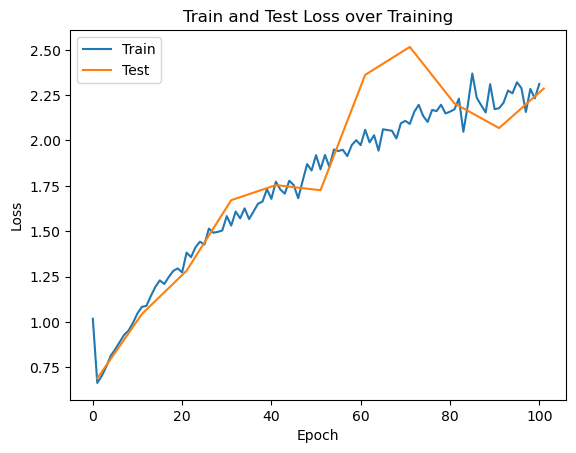

In [9]:
# plot training + test error
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Using the dropout method we drop random neurons in the training stage. By doing this over and over again we make our network more robust. The essential goal is that the network doesn't learn the noise. If a neuron only compensates the effect of another neuron it isn't helpful for optimizing the loss. This helps us creating a more generalized network, indipendent of specific data.

The Test and Training error in this implementation is way higher than the first implementation without dropout. The Network seems to struggle to train using dropout. The Only good thing is that training error and testing error don't diverge as they do in the first implementation. 

### **3 Parametric Relu**

In [10]:
#define parametric ReLU funciton:
def PRelu(X,a):
    return torch.where(X>0,X,a*X)

In [11]:
plt.rc("figure", dpi=100)

batch_size = 100

# define the neural network
def dropout_model(X, w_h, w_h2, w_o, a, p_drop_input, p_drop_hidden):
    x = dropout(X,p_drop_input)
    h = PRelu(x @ w_h,a)
    h = dropout(h, p_drop_hidden)
    h2 = PRelu(h @ w_h2,a) 
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
a = torch.tensor([0.5])
a.requires_grad = True

# output shape is (B, 10)

In [12]:
#train network
optimizer = RMSprop(params=[w_h, w_h2, w_o,a])
batch_size = 100


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, a,0.5,0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = dropout_model(x, w_h, w_h2, w_o, a, 0.5,0.5)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 1.16e+00
Mean Test Loss:  6.19e-01
Epoch: 10
Mean Train Loss: 4.36e-01
Mean Test Loss:  4.09e-01
Epoch: 20
Mean Train Loss: 4.34e-01
Mean Test Loss:  3.99e-01
Epoch: 30
Mean Train Loss: 4.23e-01
Mean Test Loss:  4.26e-01
Epoch: 40
Mean Train Loss: 4.37e-01
Mean Test Loss:  4.34e-01
Epoch: 50
Mean Train Loss: 4.47e-01
Mean Test Loss:  4.58e-01
Epoch: 60
Mean Train Loss: 4.53e-01
Mean Test Loss:  4.36e-01
Epoch: 70
Mean Train Loss: 4.66e-01
Mean Test Loss:  4.87e-01
Epoch: 80
Mean Train Loss: 4.63e-01
Mean Test Loss:  4.74e-01
Epoch: 90
Mean Train Loss: 4.76e-01
Mean Test Loss:  5.00e-01
Epoch: 100
Mean Train Loss: 4.84e-01
Mean Test Loss:  4.77e-01


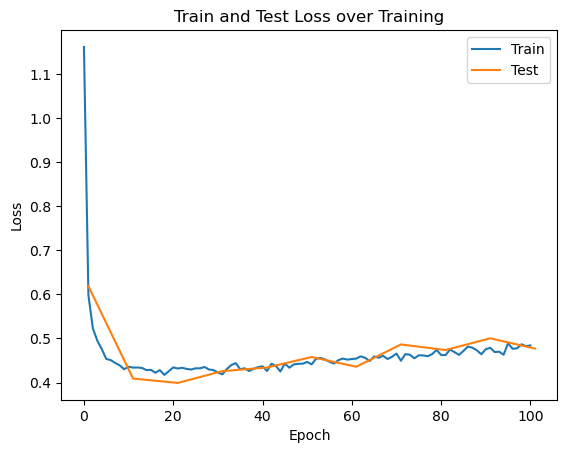

In [13]:
#plot training + test error
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Using an additional Parametric ReLu both training and test error initially decrease. They don't skyrocket as they do in task 2 but rather fluctuate around it's minimum. With longer training the error increases slightly again.

### **4 Convolutional layer**

In [14]:
trainX = train_dataset.data
testX = test_dataset.data

#make sure that the input immage has the the correct shape:
trainX = trainX.reshape(-1, 1, 28, 28)
testX = testX.reshape(-1, 1, 28, 28)

In [15]:
# define convolutional network
def cnn(X, conv_weights1, conv_weights2, conv_weights3, w_o, w_fc, a, p_drop_input, p_drop_hidden):
    x = dropout(X, p_drop_input)
    
    conv1 = rectify(conv2d(x, conv_weights1))
    subsamp1 = max_pool2d(conv1, (2,2))
    out1  = dropout(subsamp1, p_drop_hidden)
    
    conv2 = rectify(conv2d(out1, conv_weights2))
    subsamp2 = max_pool2d(conv2, (2,2))
    out2  = dropout(subsamp2, p_drop_hidden)
    
    conv3 = rectify(conv2d(out2, conv_weights3))
    subsamp3 = max_pool2d(conv3, (2,2))
    out3  = dropout(subsamp3, p_drop_hidden)
    
    out3_flat = out3.reshape(100, -1)
    
    fc4 = PRelu(out3_flat @ w_fc, a) 
    out4 = dropout(fc4, p_drop_hidden)
    
    pre_softmax = out4 @ w_o
    return pre_softmax

<div style="color: green; font-weight:bold">it is better to use torch.nn.Module as a base class for the network definition, which provides additional functionality and simplifies the code.</div>

In [16]:
# setup weights:
conv_weights1 = init_weights((32, 1, 5, 5))
conv_weights2 = init_weights((64, 32, 5, 5))
conv_weights3 = init_weights((128, 64, 2, 2))
w_fc = init_weights((128, 625))
w_o = init_weights((625, 10))
a = torch.tensor([0.5])
a.requires_grad = True

<div style="color: green; font-weight:
bold"> you can consider using PyTorch's built-in weight initialization methods (torch.nn.init) for better initialization.</div> 

In [17]:
# train network
optimizer = RMSprop(params=[conv_weights1, conv_weights2, conv_weights3, w_o, w_fc, a])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        #x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = cnn(x, conv_weights1, conv_weights2, conv_weights3, w_o, w_fc, a, 0.5, 0.5)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))
    
    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                #x = x.reshape(batch_size, 784)
                noise_py_x = cnn(x, conv_weights1, conv_weights2, conv_weights3, w_o, w_fc, a, 0.5,0.5)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

Epoch: 0
Mean Train Loss: 7.38e+00
Mean Test Loss:  2.31e+00
Epoch: 10
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 20
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 30
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 40
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 50
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 60
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 70
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 80
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 90
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00
Epoch: 100
Mean Train Loss: 2.30e+00
Mean Test Loss:  2.30e+00


<div style="color: green; font-weight:
bold">Consider trying other optimizers like Adam (torch.optim.Adam), which might provide  better performance</div> 

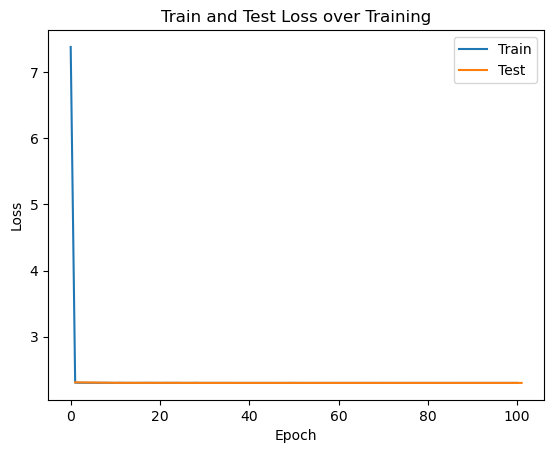

In [18]:
# plot training + test error
plt.rc("figure", dpi=100)
plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

### **4.2 Application of Convolutional Network**

![Sketch of Network](cnn_sketch.png)

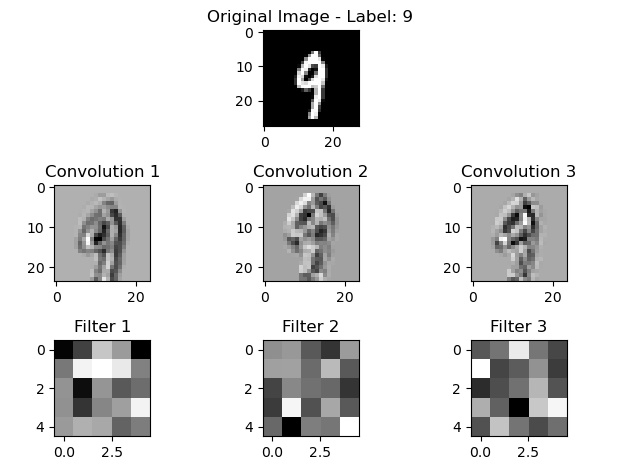

In [100]:
# Choose one image from the test set
image_index = np.random.randint(0, len(test_dataset) - 1)
image = test_dataset[image_index][0]
label = test_dataset[image_index][1]

# Apply convolution to the chosen image using three filters from the first convolutional layer
filters = conv_weights1[:3]
convolutions = [conv2d(image.unsqueeze(0), filter.unsqueeze(0)).squeeze().detach().numpy() for filter in filters]

# Visualize the convolutions and filters
fig, axes = plt.subplots(3, 3)
axes[0][1].imshow(image.reshape(28,28), cmap='gray')
axes[0][1].set_title(f"Original Image - Label: {label}")
axes[0, 0].axis('off')  # Remove the first image in the top left
axes[0, 2].axis('off')  # Remove the second image in the top right
for i in range(3):
    axes[1][i].imshow(convolutions[i], cmap='gray')
    axes[1][i].set_title(f"Convolution {i+1}")
    axes[2][i].imshow(filters[i].squeeze().detach().numpy(), cmap='gray')
    axes[2][i].set_title(f"Filter {i+1}")
plt.tight_layout()
plt.show()

<div style="color: green; font-weight:
bold">
Suggestions: 1.add labels or captions to the subplots in the visualization,  2.set a seed value using np.random.seed() when selecting a random image from the test set,  3.it is better to keep the convolved images as torch.Tensor objects instead of converting them to NumPy arrays.</div> 
